In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, AutoModel
from autoLRP.LRPBase import LRPTensor
from autoLRP.LRPModel import LRPModel
from autoLRP.plotutils import plot_bilrp_sentences  

# Setup device
device = "cpu"

# Load pre-trained model and tokenizer
model_name = "sentence-transformers/stsb-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
lrp_model = LRPModel(model)

def get_embedding_and_tokens(text):
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs["input_ids"].to(device)
    fe = model.embeddings.word_embeddings(input_ids)
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
    return LRPTensor(fe), tokens

def get_he(fe):
    he = lrp_model(inputs_embeds=fe).last_hidden_state.mean(dim=1)
    lrp_model.lrp_backpass(he)
    return he


text1 = "Hiking in the mountains"
text2 = "Drinking a coffee outside a beautiful view of the mountains"

fe1, tokens1 = get_embedding_and_tokens(text1)
fe2, tokens2 = get_embedding_and_tokens(text2)

he1 = get_he(fe1)
he2 = get_he(fe2)


sim = fe1.relevance_scores.squeeze().detach().cpu().numpy() @ fe2.relevance_scores.squeeze().detach().cpu().numpy().T



/opt/miniconda3/envs/waleed/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 768/768 [00:27<00:00, 27.82it/s]


In [2]:
fe2.relevance_scores.sum(dim=-1)

tensor([[ 0.0219, -0.0140,  0.0162,  0.0251, -0.0520, -0.0398, -0.0524,  0.0149,
          0.0020,  0.0137,  0.1869,  0.0208]])

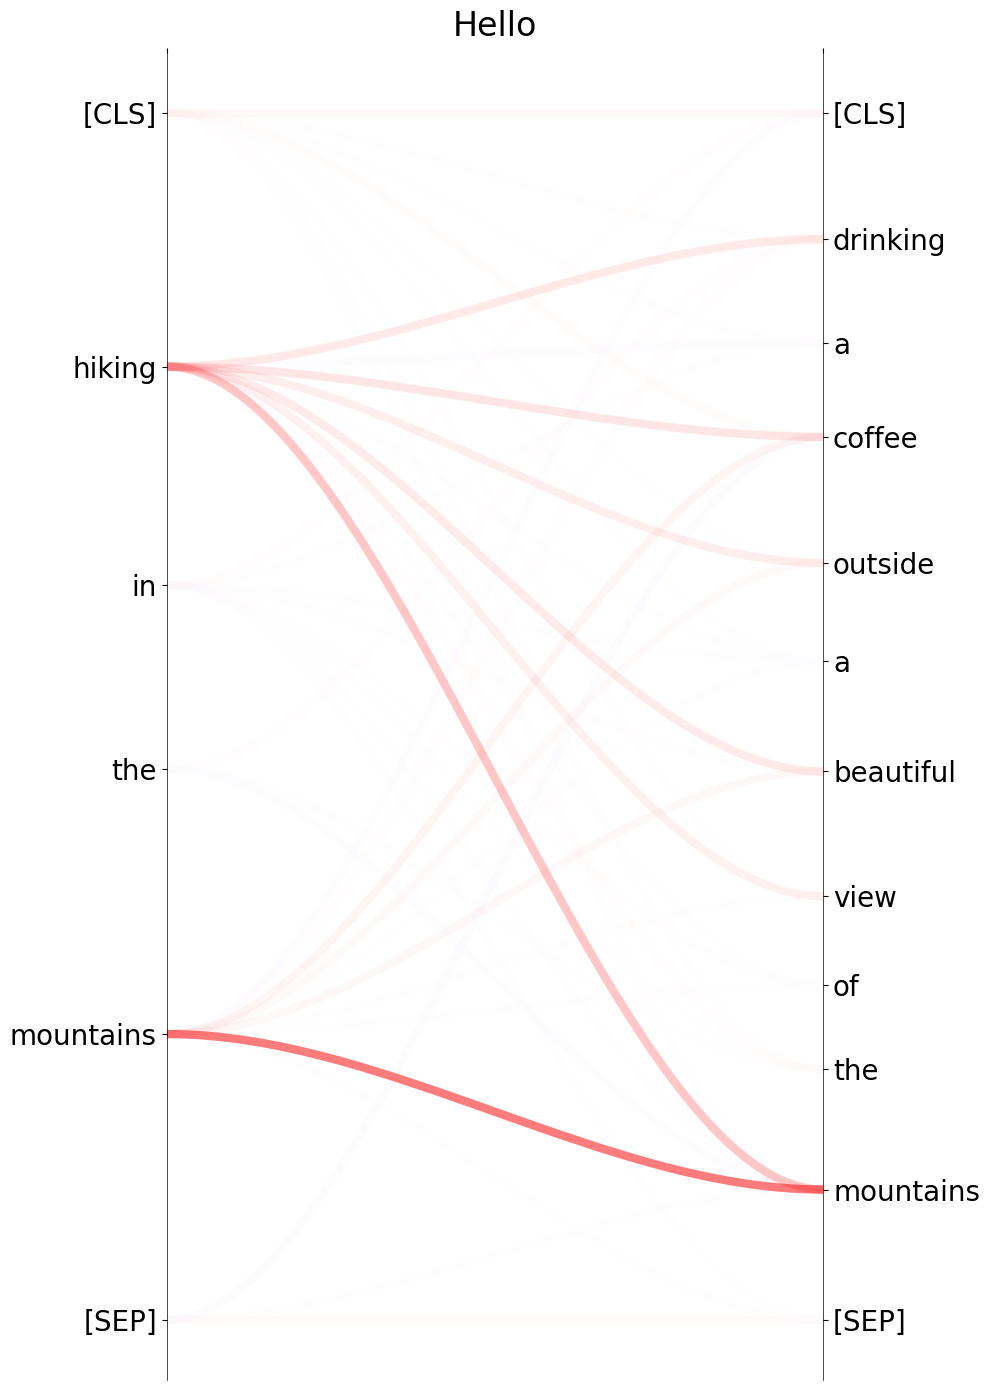

In [3]:
plot_bilrp_sentences(
    decoded=[tokens1,tokens2],
    outs=[{"Rsen": fe1.relevance_scores.squeeze().T.detach().cpu().numpy()}, {"Rsen": fe2.relevance_scores.squeeze().T.detach().cpu().numpy()}],
    relevance_scores=sim*20,
    title='Hello',
)